In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
#imports 
import numpy as np
import h5py
import scipy.io
from sklearn.metrics import confusion_matrix
import pandas as pd
from DCASE_plots import plot_confusion_matrix

import librosa
import soundfile as sound
import keras
import tensorflow
print("Librosa version = ",librosa.__version__)
print("Pysoundfile version = ",sound.__version__)
print("keras version = ",keras.__version__)
print("tensorflow version = ",tensorflow.__version__)

2024-07-02 15:32:54.096382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 15:32:55.157144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Librosa version =  0.10.1
Pysoundfile version =  0.12.1
keras version =  3.3.3
tensorflow version =  2.16.1


In [3]:
#Task 1a dev validation set
ThisPath = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/'
File = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
sr = 48000
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [4]:
File

'/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/evaluation_setup/fold1_evaluate.csv'

In [5]:
#load filenames and labels
dev_test_df = pd.read_csv(File,sep='\t', encoding='ASCII')
wavpaths = dev_test_df['filename'].tolist()
ClassNames = np.unique(dev_test_df['scene_label'])
y_val_labels =  dev_test_df['scene_label'].astype('category').cat.codes.values

#swap codes for 2 and 1 to match the DCASE ordering of classes
a1=np.where(y_val_labels==2)
a2=np.where(y_val_labels==3)
y_val_labels.setflags(write=1)
y_val_labels[a1] = 3
y_val_labels[a2] = 2

In [6]:
#load wav files and get log-mel spectrograms, deltas, and delta-deltas
def deltas(X_in):
    X_out = (X_in[:,:,2:,:]-X_in[:,:,:-2,:])/10.0
    X_out = X_out[:,:,1:-1,:]+(X_in[:,:,4:,:]-X_in[:,:,:-4,:])/5.0
    return X_out

LM_val = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,2),'float32')
for i in range(len(wavpaths)):
    stereo,fs = sound.read(ThisPath + wavpaths[i],stop=SampleDuration*sr)
    for channel in range(2):
        LM_val[i,:,:,channel]= librosa.feature.melspectrogram(y = stereo[:,channel], 
                                       sr=sr,
                                       n_fft=NumFFTPoints,
                                       hop_length=HopLength,
                                       n_mels=NumFreqBins,
                                       fmin=0.0,
                                       fmax=sr/2,
                                       htk=True,
                                       norm=None)

LM_val=np.log(LM_val)
LM_deltas_val = deltas(LM_val)
LM_deltas_deltas_val = deltas(LM_deltas_val)
LM_val = np.concatenate((LM_val[:,:,4:-4,:],LM_deltas_val[:,:,2:-2,:],LM_deltas_deltas_val),axis=-1)

In [7]:
from DCASE2019_improvised_network import PadChannels
from DCASE2019_improvised_network import SliceLayer

custom_objects = {
    'PadChannels': PadChannels,
    'SliceLayer': SliceLayer
}

#load and run the model
best_model = keras.models.load_model("DCASE_1a_Task_development_1_test.h5", custom_objects = custom_objects)
y_pred_val = np.argmax(best_model.predict(LM_val),axis=1)


2024-07-02 15:36:06.843384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39317 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1719927376.355871 1766684 service.cc:145] XLA service 0x7fa97c229d70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719927376.355914 1766684 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-07-02 15:36:16.381258: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-02 15:36:16.597300: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024-07-02 15:37:07.808946: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=0,k3=0} for conv (f32[32,1536,64,5

  1/131 ━━━━━━━━━━━━━━━━━━━━ 6:52:06 190s/step

I0000 00:00:1719927565.820961 1766684 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/131 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

2024-07-02 15:45:12.362408: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng26{k2=0,k13=2,k14=3,k18=0,k22=0,k23=0} for conv (f32[25,3072,64,29]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3072,64,29]{3,2,1,0}, f32[3072,3072,3,3]{3,2,1,0}, f32[3072]{0}, f32[25,3072,64,29]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":1,"leakyrelu_alpha":0}} is taking a while...
2024-07-02 15:45:12.474081: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.111796514s
Trying algorithm eng26{k2=0,k13=2,k14=3,k18=0,k22=0,k23=0} for conv (f32[25,3072,64,29]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,3072,64,29]{3,2,1,0}, f32[3072,3072,3,3]{3,2,1,0}, f32[3072]{0}, f32[25,3072,64,29]{3,2,1,0}), window={size=3x3 p

131/131 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step


In [8]:
y_pred_val

array([7, 2, 4, ..., 9, 9, 9])

overall accuracy:  0.5264038231780167
Normalized confusion matrix
per-class accuracy (recall):  [0.31828979 0.61445783 0.12183908 0.09237875 0.88341969 0.53488372
 0.74376417 0.58974359 0.87562189 0.55045872]
per-class precision:  [0.42138365 0.80696203 0.10663984 0.13559322 0.89033943 0.55053191
 0.57043478 0.47916667 0.76855895 0.54669704]
mean per-class recall:  0.5324857229167373
mean per-class precision:  0.5276307512934272


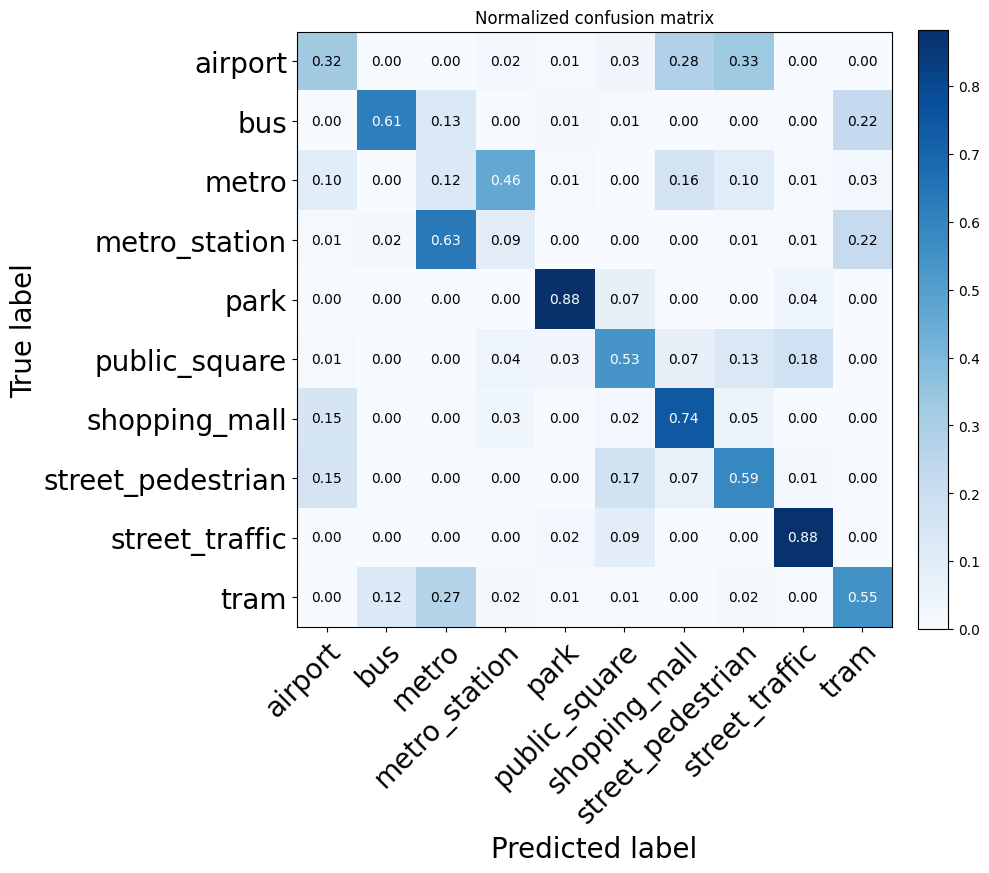

In [9]:
#get metrics
Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val.shape[0]
print("overall accuracy: ", Overall_accuracy)

plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title=None)

conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
recall_by_class = np.diagonal(conf_mat_norm_recall)
precision_by_class = np.diagonal(conf_mat_norm_precision)
mean_recall = np.mean(recall_by_class)
mean_precision = np.mean(precision_by_class)

print("per-class accuracy (recall): ",recall_by_class)
print("per-class precision: ",precision_by_class)
print("mean per-class recall: ",mean_recall)
print("mean per-class precision: ",mean_precision)

overall accuracy:  0.822700119474313
Normalized confusion matrix
per-class accuracy (recall):  [0.73634204 0.88674699 0.80689655 0.81524249 0.90932642 0.7002584
 0.80725624 0.82051282 0.93532338 0.81422018]
per-class precision:  [0.80939948 0.87410926 0.82009346 0.81902552 0.91884817 0.8041543
 0.76724138 0.8441247  0.79830149 0.78713969]
mean per-class recall:  0.82321255223722
mean per-class precision:  0.8242437446988766


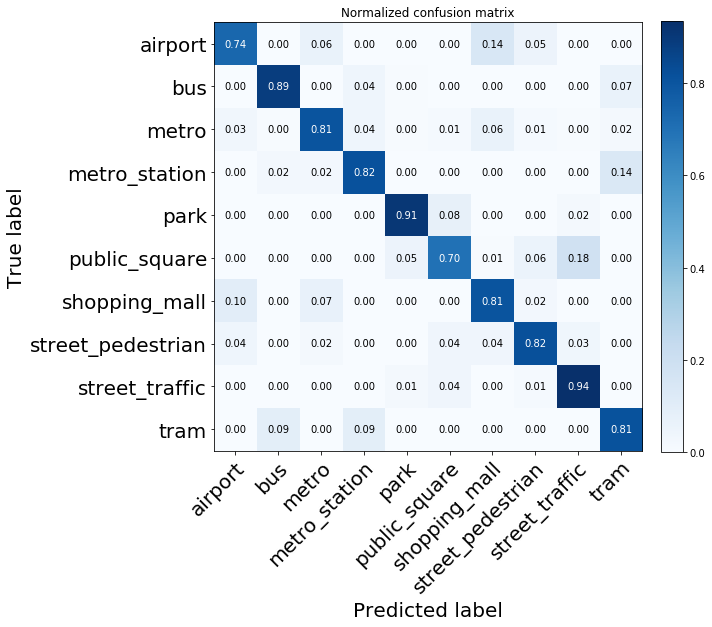

In [7]:
# #get metrics
# Overall_accuracy = np.sum(y_pred_val==y_val_labels)/LM_val.shape[0]
# print("overall accuracy: ", Overall_accuracy)

# plot_confusion_matrix(y_val_labels, y_pred_val, ClassNames,normalize=True,title=None)

# conf_matrix = confusion_matrix(y_val_labels,y_pred_val)
# conf_mat_norm_recall = conf_matrix.astype('float32')/conf_matrix.sum(axis=1)[:,np.newaxis]
# conf_mat_norm_precision = conf_matrix.astype('float32')/conf_matrix.sum(axis=0)[:,np.newaxis]
# recall_by_class = np.diagonal(conf_mat_norm_recall)
# precision_by_class = np.diagonal(conf_mat_norm_precision)
# mean_recall = np.mean(recall_by_class)
# mean_precision = np.mean(precision_by_class)

# print("per-class accuracy (recall): ",recall_by_class)
# print("per-class precision: ",precision_by_class)
# print("mean per-class recall: ",mean_recall)
# print("mean per-class precision: ",mean_precision)